In [1]:
import sys
sys.path.append('..')

from utils import *
from networks import *

import matplotlib.pyplot as plt
from optax.contrib import reduce_on_plateau
import optax

In [2]:
from typing import Type
def load_checkpoint(path : str, 
                    Network : Type[eqx.Module], 
                    opt : optax.GradientTransformation = None,
                    train_loader : jdl.DataLoader = None,
                    val_loader : jdl.DataLoader = None, 
                    epoch_idx: Optional[int] = None) -> Trainer:
    """Loads a trainer from a checkpoint, using orbax.

    Args:
        Network (Type[eqx.Module])
        opt (optax.GradientTransformation)
        abstract_opt_state (PyTree)
        train_loader (jdl.DataLoader)
        val_loader (jdl.DataLoader)
        path (str)
        epoch_idx (Optional[int], optional): Which epoch to load. Defaults to the last saved step.

    Returns:
        Trainer: the loaded trainer.
    """
    path = epath.Path(path)
    
    # First load the hparams
    with open(path / 'hparams.json', "rb") as f:
        hparams = json.load(f)
        
    #num_devices = len(jax.devices())
    #devices = mesh_utils.create_device_mesh((num_devices, 1))
    #replicated = jshard.PositionalSharding(devices).replicate()
    
    # Initialize the model with the given hparams
    abstract_model = Network(hparams)
    #abstract_model = eqx.filter_shard(Network(hparams), replicated)
    abstract_opt_state = opt.init(eqx.filter([abstract_model], eqx.is_array))
    
    # Restore the model, optimizer state as well as training history
    with ocp.CheckpointManager(path) as mngr:
        epoch_idx = epoch_idx or mngr.latest_step()
        restored = mngr.restore(
            epoch_idx, 
            args=ocp.args.Composite(
                model=EquinoxStateRestore(abstract_model),
                #opt_state=ocp.args.StandardRestore(abstract_opt_state),
                loss_history=ocp.args.StandardRestore(),
                #λ_history=ocp.args.StandardRestore(),
            )
        )
        
    # Initialize the trainer with the restored model, optimizer state and training history
    model = restored.model
    #opt_state = restored.opt_state
    
    trainer = Trainer(model, opt, abstract_opt_state, train_loader, val_loader, hparams = hparams)
    
    train_loss_history = restored.loss_history["train_loss_history"][:epoch_idx]
    val_loss_history = restored.loss_history["val_loss_history"][:epoch_idx//trainer.val_every_n_epoch]
    train_loss_history_batch = restored.loss_history["train_loss_history_batch"][:epoch_idx*len(train_loader)]
    val_loss_history_batch = restored.loss_history["val_loss_history_batch"][:(epoch_idx//trainer.val_every_n_epoch)*len(val_loader)]
    
    trainer.train_loss_history = train_loss_history
    trainer.val_loss_history = val_loss_history
    trainer.train_loss_history_batch = train_loss_history_batch
    trainer.val_loss_history_batch = val_loss_history_batch
    
    trainer.epochs_trained = epoch_idx
    
    #trainer.λ_history = restored.λ_history[0]
    
    return trainer    

In [3]:

data_path = "C:/Users/eirik/OneDrive - NTNU/5. klasse/prosjektoppgave/eirik_prosjektoppgave/data/"
data = jnp.load(data_path + "kdv.npz")

x = jnp.array(data['x'])
t = jnp.array(data['t'])
a_train = jnp.array(data['a_train'])
u_train = jnp.array(data['u_train'])
a_val = jnp.array(data['a_val'])
u_val = jnp.array(data['u_val'])
a_test = jnp.array(data['a_test'])
u_test = jnp.array(data['u_test'])

# SET PARAMETERS
P = x[-1]
T = t[-1]
M = len(x) - 1
N = len(t) - 1
NUMBER_OF_SENSORS = M + 1
N = len(t)-1

# NORMALIZE DATA
u_normalizer = UnitGaussianNormalizer(u_train)
a_normalizer = UnitGaussianNormalizer(a_train)
x_normalizer = UnitGaussianNormalizer(x)
t_normalizer = UnitGaussianNormalizer(t)

u_train_n = u_normalizer.encode(u_train)
a_train_n = a_normalizer.encode(a_train)

u_val_n = u_normalizer.encode(u_val)
a_val_n = a_normalizer.encode(a_val)

u_test_n = u_normalizer.encode(u_test)
a_test_n = a_normalizer.encode(a_test)

x_n = x_normalizer.encode(x)
t_n = t_normalizer.encode(t)

# Set x and t as class attributes, since they are constant throughout the training
Trainer.x = x_n
Trainer.t = t_n

train_loader = jdl.DataLoader(jdl.ArrayDataset(a_train_n, u_train_n), batch_size=16, shuffle=True, backend='jax', drop_last=True)
val_loader = jdl.DataLoader(jdl.ArrayDataset(a_val_n, u_val_n), batch_size=16, shuffle=True, backend='jax', drop_last=True)

In [5]:
path = "C:/Users/eirik/orbax/hno_kdv"
path = epath.Path(path)
    
# First load the hparams
with open(path / 'hparams.json', "rb") as f:
    hparams_operator_net = json.load(f)
    
PATIENCE = 5 # Number of epochs with no improvement after which learning rate will be reduced
COOLDOWN = 0 # Number of epochs to wait before resuming normal operation after the learning rate reduction
FACTOR = 0.5  # Factor by which to reduce the learning rate:
RTOL = 1e-4  # Relative tolerance for measuring the new optimum:
ACCUMULATION_SIZE = 200 # Number of iterations to accumulate an average value:
    

operator_net = ModifiedDeepONet(hparams_operator_net["operator_net"])
hparams_energy_net = hno.EnergyNetHparams(depth=5, width=100, learning_rate=1e-3)
energy_net = hno.EnergyNet(hparams_energy_net)

abstract_model = hno.HamiltonianNeuralOperatorDON(energy_net, operator_net)

with ocp.CheckpointManager(path) as mngr:
    epoch_idx = mngr.latest_step()
    restored = mngr.restore(
        epoch_idx, 
        args=ocp.args.Composite(
            model=EquinoxStateRestore(abstract_model),
            #opt_state=ocp.args.StandardRestore(abstract_opt_state),
            loss_history=ocp.args.StandardRestore(),
            #λ_history=ocp.args.StandardRestore(),
        )
    )
    
# Initialize the trainer with the restored model, optimizer state and training history
model_hno = restored.model
loss_history = restored.loss_history

In [14]:
import diffrax
from diffrax import diffeqsolve, ODETerm, Tsit5, SaveAt
def predict_whole_grid(model, a, x, t):
    """Since the model predicts 𝒢δℋ (=u_t),
    we have to integrate the prediction to get u.
    Does so using an ODE solver (Tsit5() in Diffrax)

    Args:
        a (Mp1,): initial condition
        x (Mp1,): spatial grid
        t (Np1,): temporal grid

    Returns:
        u (Np1, Mp1): prediction for the given grid
    """
    def f(t, y, x):
        # vmap over the spatial dimension 
        # (model takes scalar values. t is scalar, but x is an array)
        res = vmap(model, (None, 0, None))(a[::4], x, t)
        return res
    
    term = ODETerm(f)
    solver = Tsit5()
    saveat = SaveAt(ts=t)
    solution = diffeqsolve(term, 
                            solver, 
                            t0=t[0],
                            t1=t[-1], 
                            dt0=t[1]-t[0], 
                            y0=a, 
                            args=x, 
                            saveat=saveat)
    return solution.ys

In [26]:
u_pred_hno = u_normalizer.decode(predict_whole_grid(model_hno, a_train_n[0], x_n, t_n))

In [29]:
u_pred_don = u_normalizer.decode(model_hno.u.predict_whole_grid(a_train_n[0,::4], x_n, t_n))

In [22]:
#############SPATIAL DERIVATIVES####################
def Dx(y, dx, order = 6):
    """Assumes periodic boundary conditions"""
    order = 4
    y_p_1 = jnp.roll(y, shift=-1)
    y_m_1 = jnp.roll(y, shift=1)
    if order == 2:
        return (y_p_1 - y_m_1) / (2 * dx)
    elif order == 4:
        y_p_2 = jnp.roll(y, shift=-2)
        y_m_2 = jnp.roll(y, shift=2)
        return (-y_p_2 + 8*y_p_1 - 8*y_m_1 + y_m_2)/(12*dx)
    elif order == 6:
        y_p_2 = jnp.roll(y, shift=-2)
        y_m_2 = jnp.roll(y, shift=2)
        y_p_3 = jnp.roll(y, shift=-3)
        y_m_3 = jnp.roll(y, shift=3)
        return (y_p_3 - 9*y_p_2 + 45*y_p_1 - 45*y_m_1 + 9*y_m_2 - y_m_3)/(60*dx)
    else:
        raise ValueError("Only 2nd, 4th and 6th order accurate first derivatives are implemented")
        

def Dxx(y, dx, order = 6):
    """Assumes periodic boundary conditions"""
    order = 4
    y_p_1 = jnp.roll(y, shift=-1)
    y_m_1 = jnp.roll(y, shift=1)
    
    if order == 2:
        return (y_p_1 - 2 * y + y_m_1) / dx**2
    elif order == 4:
        y_p_2 = jnp.roll(y, shift=-2)
        y_m_2 = jnp.roll(y, shift=2)
        return (-y_p_2+16*y_p_1-30*y+16*y_m_1-y_m_2)/(12*dx**2)
    elif order == 6:
        y_p_2 = jnp.roll(y, shift=-2)
        y_m_2 = jnp.roll(y, shift=2)
        y_p_3 = jnp.roll(y, shift=-3)
        y_m_3 = jnp.roll(y, shift=3)
        return (270*y_m_1 - 27*y_m_2 + 2*y_m_3 + 270*y_p_1 - 27*y_p_2 + 2*y_p_3 - 490*y) / (180*dx**2)
    else:
        raise ValueError("Only 2nd, 4th and 6th order accurate second derivatives are implemented")


In [23]:
def H_energy(u, args):
    η, γ, dx = args["η"], args["γ"], args["dx"]
    integrand = -η/6*u**3 + 0.5*γ**2*Dx(u, dx)**2
    return dx*jnp.sum(integrand)

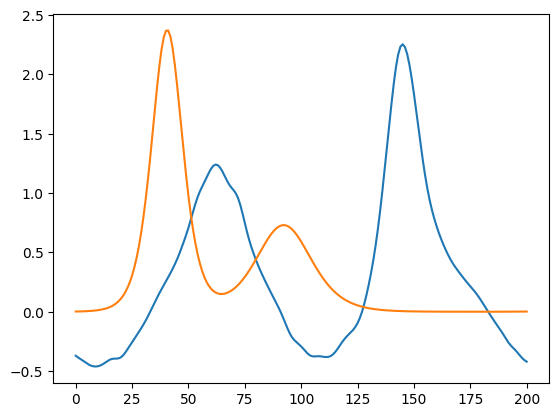

In [57]:
#plt.plot(u_pred_don[0])
plt.plot(u_pred_hno[-1])
plt.plot(u_train[0,-1])

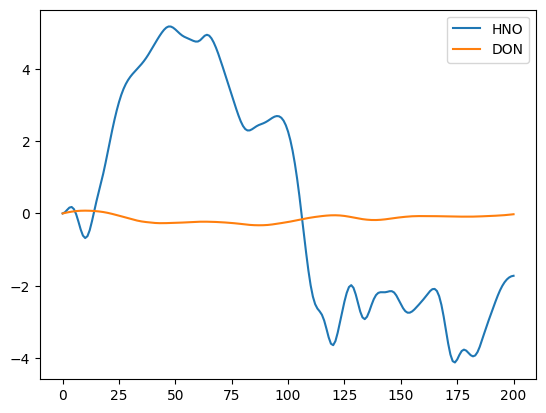

In [34]:
Hs_hno = vmap(H_energy, (0, None))(u_pred_hno, {"η": 6., "γ": 1, "dx": x[1]-x[0]})
Hs_don = vmap(H_energy, (0, None))(u_pred_don, {"η": 6., "γ": 1, "dx": x[1]-x[0]})

plt.plot(Hs_hno-Hs_hno[0], label="HNO")
plt.plot(Hs_don-Hs_don[0], label="DON")
plt.legend()